In [0]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# !pip3 install -U torch torchvision
import torch
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.__version__, cuda

('1.1.0', False)

# MNIST, MLP

https://github.com/udacity/deep-learning-v2-pytorch/blob/master/gan-mnist/MNIST_GAN_Solution.ipynb

In [0]:
import torch

imgsize = 28
batch_size = 64  # how many samples per batch to load
z_size = 28*28
print_every=100
epochs = 5
patience = 2  #early stopping
lr = 0.002

## Load Data

In [4]:
from torchvision import datasets, transforms

train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
print(len(train_data))

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 27111321.67it/s]                            


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 439700.53it/s]
0it [00:00, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 7262976.25it/s]                           
8192it [00:00, 169948.80it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
60000


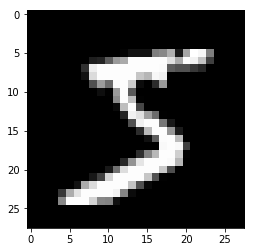

In [5]:
#visualize
images, labels = next(iter(train_loader))
plt.imshow(np.squeeze(images[0]), cmap='gray')

## Model

### Discriminator

linear classifier, with 3 hidden layers, using [Leaky Relu](https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU) activation, where for $x<0$ the slope is slightly positive

outputs single number indicating *real*/*fake*

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim=32, output_size=1):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)        
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        self.dropout = nn.Dropout(0.3)        
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        
        return self.fc4(x)

D = Discriminator(input_size=784, hidden_dim=32, output_size=1).to(device)
print(D)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3)
)


In [7]:
images, labels = next(iter(train_loader))
print(images.shape)
print(D(images.to(device)).shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 1])


### Generator

* inputs 784 random numbers, outputs 784 pixels
* Use `torch.tanh` instead of `torch.sigmoid` for output (why?)

In [8]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim=32, output_size=784):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        
        return torch.tanh(self.fc4(x))

G = Generator(input_size=784, hidden_dim=32, output_size=784).to(device)
print(G)

Generator(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3)
)


### Losses

* Use BCEWithLogitsLoss since D outputs just a number
* To help D generalize better, the true labels are **reduced from 1.0 to 0.9**
* Use different optimizer objects for Discriminator and Generator

In [0]:
d_criterion = lambda pred, true: nn.BCEWithLogitsLoss()(pred,true*0.9)
g_criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr)
g_optimizer = torch.optim.Adam(G.parameters(), lr)

## Train

In [0]:
# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=8
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
def view_samples(epoch, samples, nrows=2, ncols=4):
    fig, axes = plt.subplots(figsize=(1.5*ncols,1.5*nrows), nrows=nrows, ncols=ncols, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.cpu().detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    plt.show()

In [86]:
samples = []   # saves samples so visualize how the image quality improves over epochs

D.train()
G.train()
for epoch in range(epochs):
    for batch_i, (real_images, _) in enumerate(train_loader):                
        batch_size = real_images.size(0)        
        real_images = real_images*2 - 1  # rescale to [-1, 1) as G generates to this range
        
        # ============TRAIN THE DISCRIMINATOR=========        
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))  #generates fake img
        z = torch.from_numpy(z).float()
        fake_images = G(z.to(device)).view_as(real_images)
        
        allimages = torch.cat((real_images.to(device), fake_images.to(device)), 0)  #concat on 0th axis
        alllabels = torch.cat((torch.ones(batch_size),torch.zeros(batch_size)), 0).to(device)
        
        d_optimizer.zero_grad()
        pred = D(allimages.to(device)).squeeze()
        d_loss = d_criterion(pred,alllabels)
        d_loss.backward()
        d_optimizer.step()      
        print(allimages.shape)

        # ===========TRAIN THE GENERATOR=============
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))  #generates fake img
        z = torch.from_numpy(z).float()
        fake_images = G(z.to(device))
        
        g_optimizer.zero_grad()
        pred = D(fake_images.to(device)).squeeze()
        g_loss = g_criterion(pred, torch.ones(batch_size).to(device)) #min loss -> make D think the images are real        
        g_loss.backward()
        g_optimizer.step()

        if batch_i % print_every == 0:
            print(f'Epoch {epoch+1:5d} | d_loss: {d_loss.item():6.4f} | g_loss: {g_loss.item():6.4f}')

    from IPython.display import clear_output
    clear_output()
    G.eval()
    samples += G(fixed_z.to(device)),
    G.train()
    view_samples(-1,samples,1,8)

torch.Size([128, 1, 28, 28])


## Evaluate

### Visualize training progress

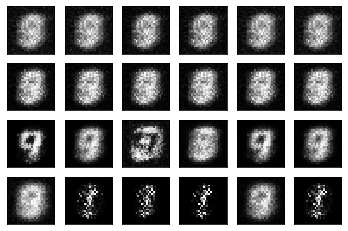

In [24]:
nrows = 4 # split epochs into 10, so 100/10 = every 10 epochs
ncols = 6
fig, axes = plt.subplots(figsize=(ncols,nrows), nrows=nrows, ncols=ncols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/nrows)], axes):
    for img, ax in zip(sample[::int(len(sample)/ncols)], ax_row):
        img = img.cpu().detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

### Generate new

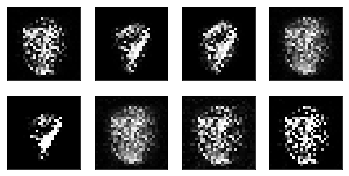

In [25]:
G.eval()

sample_size=8
rand_z = np.random.uniform(-1, 1, size=(sample_size, imgsize*imgsize))
rand_z = torch.from_numpy(rand_z).float()
rand_images = G(rand_z.to(device))

view_samples(0, [rand_images])

# Street View House Number, Convolutional

https://github.com/udacity/deep-learning-v2-pytorch/blob/master/dcgan-svhn/DCGAN_Solution.ipynb

In [0]:
batch_size = 128
imgsize = [3,32,32]
z_size = 100
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

print_every = 300
epochs = 50

## Data

In [93]:
from torchvision import datasets, transforms
from itertools import chain

data = datasets.SVHN(root='~/.pytorch/SVHN_data/', split='train', download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=data, batch_size=batch_size, shuffle=True)

  0%|          | 0/182040794 [00:00<?, ?it/s]

182042624it [00:07, 24851038.07it/s]                               


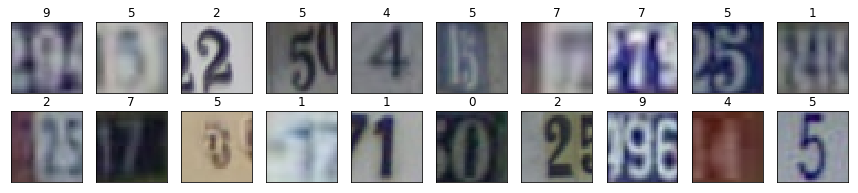

In [94]:
# visualize
images, labels = next(iter(train_loader))

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(15, 3))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(str(labels[idx].item()))

In [0]:
# Preprocessor
def scale(x, feature_range=(-1, 1)):
    m, M = feature_range
    x = x * (M - m) + m  # x is originally [0,1]
    return x

## Model

### Discriminator

<img src="https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/dcgan-svhn/assets/conv_discriminator.png" width="500px">
each layer should look something like convolution > batch norm > leaky ReLU, and so we'll define a function to put these layers together.

In [96]:
import torch.nn as nn
import torch.nn.functional as F

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):   # helper
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)]
    if batch_norm: layers.append(nn.BatchNorm2d(out_channels))     
    return nn.Sequential(*layers)

class Discriminator(nn.Module):
    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()

        self.conv_dim = conv_dim

       
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # in 32x32; out 16x16; first layer, no batch_norm        
        self.conv2 = conv(conv_dim, conv_dim*2, 4)          # in 16x16; out 8x8       
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)        # in 8x8  ; out 4x4
        
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        out = out.view(-1, self.conv_dim*4*4*4)
        out = self.fc(out)        
        return out

D = Discriminator(conv_dim=imgsize[1]).to(device)
print(D)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)


### Generator

<img src="https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/dcgan-svhn/assets/conv_generator.png" width="600px">

* output will be a nn.tanh output
* series of transpose convolutional layers, where you typically halve the depth and double the width and height of the previous layer.
* batch normalization and ReLU to all but the last of these hidden layers


In [97]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = [nn.ConvTranspose2d(in_channels, out_channels, 
                                 kernel_size, stride, padding, bias=False) ]
    if batch_norm: layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()
        
        self.conv_dim = conv_dim
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)

        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))        
        out = torch.tanh(self.t_conv3(out))
        
        return out
    
G = Generator(z_size=z_size, conv_dim=imgsize[1]).to(device)
print(G)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv3): Sequential(
    (0): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)


### Losses

* Use BCEWithLogitsLoss since D outputs just a number
* To help D generalize better, the true labels are **reduced from 1.0 to 0.9**
* Use different optimizer objects for Discriminator and Generator
* A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other

In [0]:
d_criterion = nn.BCEWithLogitsLoss()#lambda pred, true: fn(pred,true*0.9)
g_criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = torch.optim.Adam(G.parameters(), lr, [beta1, beta2])

## Train

In [0]:
# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=8
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
def view_samples(epoch, samples, nrows=2, ncols=4):
    fig, axes = plt.subplots(figsize=(1.5*ncols,1.5*nrows), nrows=nrows, ncols=ncols, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)), cmap='Greys_r')
    plt.show()

In [72]:
samples = []   # saves samples to visualize how the image quality improves over epochs

D.train()
G.train()
for epoch in range(epochs):
    for batch_i, (real_images, _) in enumerate(train_loader):                
        batch_size = real_images.size(0)        
        real_images = scale(real_images)  # to (-1,1)
        
        # ============TRAIN THE DISCRIMINATOR=========        
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))  #generates fake img
        z = torch.from_numpy(z).float()
        fake_images = G(z.to(device)).view_as(real_images)
        
        allimages = torch.cat((real_images.to(device), fake_images), 0)  #concat on 0th axis
        alllabels = torch.cat((torch.ones(batch_size),torch.zeros(batch_size)), 0).to(device)
        
        d_optimizer.zero_grad()
        pred = D(allimages.to(device)).squeeze()
        d_loss = d_criterion(pred,alllabels)
        d_loss.backward()
        d_optimizer.step()        
        
        # ===========TRAIN THE GENERATOR=============
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))  #generates fake img
        z = torch.from_numpy(z).float()
        fake_images = G(z.to(device))
        
        g_optimizer.zero_grad()
        pred = D(fake_images.to(device)).squeeze()
        g_loss = g_criterion(pred, torch.ones(batch_size).to(device)) #min loss -> make D think the images are real        
        g_loss.backward()
        g_optimizer.step()

        if batch_i % print_every == 0:
            print(f'Epoch {epoch+1:5d} | d_loss: {d_loss.item():6.4f} | g_loss: {g_loss.item():6.4f}')
        
    from IPython.display import clear_output
    clear_output()
    G.eval()
    samples += G(fixed_z.to(device)),
    G.train()
    view_samples(-1,samples,1,8)

Epoch     1 | d_loss: 0.3837 | g_loss: 1.9198
Epoch     1 | d_loss: 0.0065 | g_loss: 0.0074


KeyboardInterrupt: ignored

In [99]:
samples = []   # saves samples to visualize how the image quality improves over epochs

D.train()
G.train()

for epoch in range(1):    
    for batch_i, (real_images, _) in enumerate(train_loader):                
        batch_size = real_images.size(0)
        
        # important rescaling step
        real_images = scale(real_images)
        
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))  #generates fake img
        z = torch.from_numpy(z).float()
        fake_images = G(z.to(device)).view_as(real_images)
        
        allimages = torch.cat((real_images.to(device), fake_images), 0)  #concat on 0th axis
        print(allimages.shape)
        alllabels = torch.cat((torch.ones(batch_size),torch.zeros(batch_size)), 0).to(device)
        
        d_optimizer.zero_grad()
        pred = D(allimages.to(device)).squeeze()
        d_loss = d_criterion(pred,alllabels)
        print(d_criterion(pred[:batch_size],alllabels[:batch_size]),d_criterion(pred[batch_size:],alllabels[batch_size:]),d_loss)
        d_loss = real_loss(D(real_images.to(device)))+fake_loss(D(fake_images.to(device)))
        print(real_loss(D(real_images.to(device))),fake_loss(D(fake_images.to(device))),d_loss)
        break
        d_loss.backward()
        d_optimizer.step()
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))  #generates fake img
        z = torch.from_numpy(z).float()
        fake_images = G(z.to(device))
        
        g_optimizer.zero_grad()
        pred = D(fake_images.to(device)).squeeze()
        g_loss = g_criterion(pred, torch.ones(batch_size).to(device)) #min loss -> make D think the images are real  
        g_loss.backward()
        g_optimizer.step()
        
        # Print some loss stats
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##    
    # generate and save sample, fake images
    G.eval() # for generating samples
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to training mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

torch.Size([256, 3, 32, 32])
tensor(0.8712, grad_fn=<BinaryCrossEntropyWithLogitsBackward>) tensor(0.5764, grad_fn=<BinaryCrossEntropyWithLogitsBackward>) tensor(0.7238, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.8619, grad_fn=<BinaryCrossEntropyWithLogitsBackward>) tensor(0.5652, grad_fn=<BinaryCrossEntropyWithLogitsBackward>) tensor(1.4270, grad_fn=<AddBackward0>)


NameError: ignored

In [100]:
d_criterion(pred,alllabels)

tensor(0.7238, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [114]:
D(allimages.to(device)[:1000])

tensor([[ 0.1008],
        [ 0.5419],
        [ 0.6316],
        [ 3.1895],
        [ 1.3012],
        [ 1.7437],
        [ 0.8539],
        [ 1.7696],
        [ 0.1352],
        [ 3.0979],
        [ 2.6230],
        [ 4.2334],
        [-1.4558],
        [ 0.4901],
        [-0.3194],
        [ 1.3097],
        [ 2.1211],
        [ 0.5783],
        [ 0.8592],
        [-0.2916],
        [-0.0772],
        [ 2.6970],
        [ 0.7241],
        [ 0.2691],
        [ 2.0524],
        [ 1.3546],
        [-0.4458],
        [-1.9873],
        [-1.4956],
        [ 1.3029],
        [ 4.4870],
        [ 0.1548],
        [ 1.7472],
        [ 0.2810],
        [ 2.7639],
        [ 1.9816],
        [ 1.0668],
        [ 0.7955],
        [ 3.2209],
        [ 2.6918],
        [-0.0673],
        [ 3.8225],
        [-1.8538],
        [ 1.8332],
        [ 1.9228],
        [ 2.1148],
        [ 0.8777],
        [-0.8560],
        [-0.2008],
        [ 1.2765],
        [ 0.1454],
        [ 2.1353],
        [ 0.

In [93]:
real_images.to(device)[0]-allimages.to(device)[0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0',
       grad_fn=<SubBackward0>)

In [0]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Evaluate